# Feb 22nd, 2022 (GLM Ca)

**Motivation**: GLM using all animals for Ca data <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## All runs

In [2]:
mice = Mice(128)
mice.setup_func_data('led')
nn = len(mice.node_lookup['ca2'])
df_st = mice.load_stim_times('ca2')

In [3]:
duration = 4
fwd = 35
bwd = 15

data_led = []
data_rest = []
for key, (sub, ses, run) in mice.looper.items():
    if key in mice.looper_agg:
        continue
    df = df_st.loc[df_st['key'] == key]
    stim = df['stim'].values
    on = np.where(np.diff(stim) > 0)[0] + 1
    off = np.where(np.diff(stim) < 0)[0] + 1
    if not (len(on) and len(off)):
        continue
    
    base = Base(mice, key=key, mode='ca2')

    selected_periods = [range(j - duration, j) for j in off]
    ids_led = []
    for r in selected_periods:
        ids_led.extend(list(r))
    ids_led = np.array(ids_led)
    
    control_periods = [range(j + fwd - duration, j + fwd) for j in off]
    ids_rest = []
    for r in control_periods:
        ids_rest.extend(list(r))
    if max(ids_rest) > base.data.shape[-1]:
        control_periods = [range(j - bwd - duration, j - bwd) for j in on]
        ids_rest = []
        for r in control_periods:
            ids_rest.extend(list(r))
    ids_rest = np.array(ids_rest)
    
    assert max(ids_rest) < base.data.shape[-1]
    assert min(ids_rest) > 0
    
    data_led.append(base.data[:, ids_led])
    data_rest.append(base.data[:, ids_rest])
    
data_led = np.concatenate(data_led, axis=1)
data_rest = np.concatenate(data_rest, axis=1)
data_all = np.concatenate([data_led, data_rest], axis=1)
y = [1] * data_led.shape[-1] + [0] * data_rest.shape[-1]
y = np.array(y)

data_led.shape, data_rest.shape, data_all.shape, y.shape

((174, 3040), (174, 3040), (174, 6080), (6080,))

In [4]:
good_nodes = np.isnan(data_all).sum(1) == 0
x = data_all[good_nodes]

x.shape

(106, 6080)

In [5]:
from sklearn import linear_model
ner = Normalizer()

In [6]:
glm = linear_model.PoissonRegressor(
    alpha=1000,
    max_iter=int(1e5),
).fit(x.T, y)

In [7]:
c_glm = np.zeros(len(base.n2l))
c_glm[good_nodes] = glm.coef_
c_glm = ner.fit_transform(c_glm.reshape(1, -1))
c_glm = c_glm.ravel()
if max(c_glm, key=abs) < 0:
    c_glm *= -1

In [8]:
proj = base.project_vec(c_glm, thres=min(c_glm), add_disjoint=False)
trp = base.trim2d(proj)

## Save fig

In [9]:
fig_dir = pjoin(tmp_dir, 'fig_grant')
os.makedirs(fig_dir, exist_ok=True)

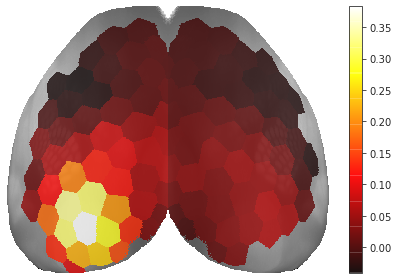

In [11]:
fig, ax = create_figure(1, 1, (6, 4))

x2plt = np.ma.masked_where(trp['top'] == 0, trp['top'])
ax.imshow(x2plt, cmap='Greys_r')

x2plt = trp['proj-top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
im = ax.imshow(x2plt, cmap='hot', alpha=0.75)
plt.colorbar(im, ax=ax)
remove_ticks(ax)

name = f'GLM-N{mice.cfg.nn}'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')

plt.show()